<a href="https://colab.research.google.com/github/Roopini-1512/Time-Series/blob/main/Covid_Prediction_using_Fbprophet_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fbprophet

# Predicting covid outbreak using FB prophet

Data-source: John hopkins university github repo 
* https://github.com/CSSEGISandData
* confirmed cases - https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv
* Deaths -https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv
* Recovered - https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv



In [ ]:
#latest updated file - last update-10th jan 2021 11.00am
# c_url = "https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
# d_url = "https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv" 
# r_url = "https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"
#found some error while specifying the autoupdated url(someone workaround needed)
#so lets load from our pc

In [ ]:
from google.colab import files 
uploaded = files.upload()

Saving time_series_covid19_confirmed_global.csv to time_series_covid19_confirmed_global.csv
Saving time_series_covid19_deaths_global.csv to time_series_covid19_deaths_global.csv
Saving time_series_covid19_recovered_global.csv to time_series_covid19_recovered_global.csv


In [ ]:
import io

c_df = pd.read_csv(io.BytesIO(uploaded['time_series_covid19_confirmed_global.csv']))
d_df = pd.read_csv(io.BytesIO(uploaded['time_series_covid19_deaths_global.csv']))
r_df = pd.read_csv(io.BytesIO(uploaded['time_series_covid19_recovered_global.csv']))

In [ ]:
import pandas as pd
#lets melt the data
def melt_data(df,case_type):
    melted_df = df.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'])
    melted_df.rename(columns={"variable":"Date","value":case_type},inplace=True)
    return melted_df

In [ ]:
c_df = melt_data(c_df,"Confirmed")
d_df = melt_data(d_df,"Deaths")
r_df = melt_data(r_df,"Recovered")

In [ ]:
c_df.head()
#we have one year of data -> starting from 22nd jan 2020 till 9th jan 2021 

,Province/State,Country/Region,Lat,Long,Date,Confirmed
0,NaN,Afghanistan,33.93911,67.709953,1/22/20,0
1,NaN,Albania,41.15330,20.168300,1/22/20,0
2,NaN,Algeria,28.03390,1.659600,1/22/20,0
3,NaN,Andorra,42.50630,1.521800,1/22/20,0
4,NaN,Angola,-11.20270,17.873900,1/22/20,0


In [ ]:
c_df.tail()

,Province/State,Country/Region,Lat,Long,Date,Confirmed
96283,NaN,Vietnam,14.058324,108.277199,1/9/21,1513
96284,NaN,West Bank and Gaza,31.952200,35.233200,1/9/21,146701
96285,NaN,Yemen,15.552727,48.516388,1/9/21,2104
96286,NaN,Zambia,-13.133897,27.849332,1/9/21,26567
96287,NaN,Zimbabwe,-19.015438,29.154857,1/9/21,20499


In [ ]:
#lets merge these dfs
def merge_df(c_df,d_df,r_df):
    new_df = c_df.join(d_df['Deaths']).join(r_df['Recovered'])
    return new_df

df = merge_df(c_df,d_df,r_df)
df.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,NaN,Afghanistan,33.93911,67.709953,1/22/20,0,0,0.0
1,NaN,Albania,41.15330,20.168300,1/22/20,0,0,0.0
2,NaN,Algeria,28.03390,1.659600,1/22/20,0,0,0.0
3,NaN,Andorra,42.50630,1.521800,1/22/20,0,0,0.0
4,NaN,Angola,-11.20270,17.873900,1/22/20,0,0,0.0


In [ ]:
df.tail()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
96283,NaN,Vietnam,14.058324,108.277199,1/9/21,1513,35,NaN
96284,NaN,West Bank and Gaza,31.952200,35.233200,1/9/21,146701,1583,NaN
96285,NaN,Yemen,15.552727,48.516388,1/9/21,2104,610,NaN
96286,NaN,Zambia,-13.133897,27.849332,1/9/21,26567,464,NaN
96287,NaN,Zimbabwe,-19.015438,29.154857,1/9/21,20499,483,NaN


In [ ]:
df.columns

Index(['Province/State', 'Country/Region', 'Lat', 'Long', 'Date', 'Confirmed',
       'Deaths', 'Recovered'],
      dtype='object')

In [ ]:
#lets groupby dates -> no. confirmed, deaths and recovered
df_day = df.groupby("Date")[["Confirmed", "Deaths", "Recovered"]].sum()
df_day.head()

,Confirmed,Deaths,Recovered
Date,,,
1/1/21,83967133,1827646,0.0
1/2/21,84594632,1835892,0.0
1/22/20,555,17,28.0
1/23/20,654,18,30.0
1/24/20,941,26,38.0


First 2 dates are for 2021, lets omit those and proceed.

In [ ]:
df_day = df_day[2:]
df_day.head()

,Confirmed,Deaths,Recovered
Date,,,
1/22/20,555,17,28.0
1/23/20,654,18,30.0
1/24/20,941,26,38.0
1/25/20,1434,42,84.0
1/26/20,2118,56,62.0


In [ ]:
df_day.describe()

,Confirmed,Deaths,Recovered
count,3.520000e+02,3.520000e+02,3.520000e+02
mean,2.342113e+07,6.719221e+05,1.470913e+07
std,2.514392e+07,5.528221e+05,1.659504e+07
min,5.550000e+02,1.700000e+01,0.000000e+00
25%,2.399012e+06,1.686425e+05,2.813535e+05
50%,1.368339e+07,5.837765e+05,6.815932e+06
75%,3.762475e+07,1.078839e+06,2.696206e+07
max,8.963009e+07,1.926544e+06,5.839630e+07


Recovered is very less as compared to confirmed, we know that still we don't have complete access to vaccine.

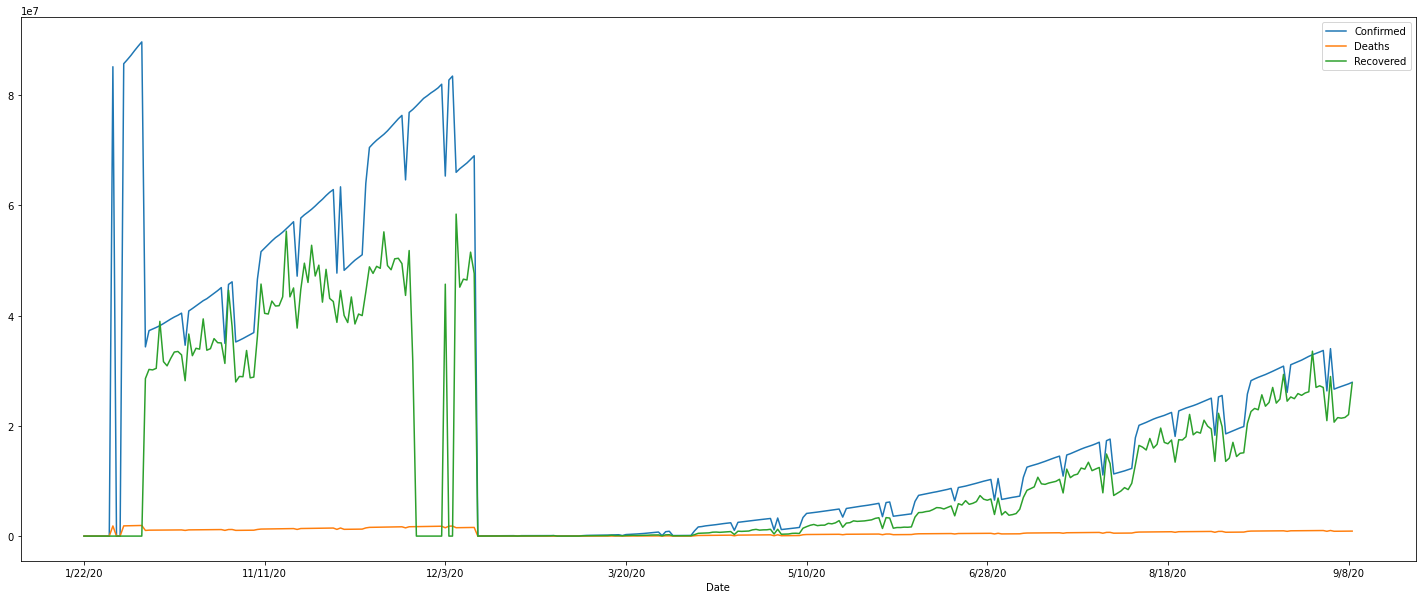

In [ ]:
df_day.plot(kind="line", figsize=(25,10));

In [ ]:
import fbprophet
dir(fbprophet)

['Prophet',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 'diagnostics',
 'forecaster',
 'hdays',
 'make_holidays',
 'models',
 'plot']

We have mae holidays, diagnostics class -> this is one of the advvantages of prophet

In [ ]:
#model
from fbprophet import Prophet
model = Prophet()

In [ ]:
#lets add some seasonlaity to it
model.add_seasonality(name="month",period=30.5 , fourier_order=5)

In [ ]:
#period = 30.5 is minimum

In [ ]:
#let's reset the index
df_final = df_day.reset_index() 
df_final.head()

,Date,Confirmed,Deaths,Recovered
0,1/22/20,555,17,28.0
1,1/23/20,654,18,30.0
2,1/24/20,941,26,38.0
3,1/25/20,1434,42,84.0
4,1/26/20,2118,56,62.0


Fb Prophet takes in only two variables : ds and y.

The input to Prophet is always a dataframe with two columns: ds and y. The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. The y column must be numeric, and represents the measurement we wish to forecast

In [ ]:
#lets split the dataset
confirmed_df = df_final[["Date", "Confirmed"]]
confirmed_df.rename(columns = {"Date":"ds","Confirmed":"y"}, inplace=True)
recovered_df = df_final[["Date", "Recovered"]]
recovered_df.rename(columns = {"Date":"ds","Recovered":"y"}, inplace=True)
deaths_df = df_final[["Date", "Deaths"]]
deaths_df.rename(columns = {"Date":"ds","Deaths":"y"}, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Confirmed cases forecast:

In [ ]:
confirmed_df.shape

(352, 2)

In [ ]:
#Lets forecast for last 2 days
#train = 350, test = 2
train_c = confirmed_df[:350]
test_c = confirmed_df[350:]

train_c

,ds,y
0,1/22/20,555
1,1/23/20,654
2,1/24/20,941
3,1/25/20,1434
4,1/26/20,2118
...,...,...
345,9/30/20,33999522
346,9/4/20,26645151
347,9/5/20,26915102
348,9/6/20,27145852


In [ ]:
# let's fit our model
model.fit(train_c)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
# let's create some future dates for plotting purpose
future_dates = model.make_future_dataframe(periods =10)
future_dates

,ds
0,2020-01-22
1,2020-01-23
2,2020-01-24
3,2020-01-25
4,2020-01-26
...,...
355,2021-01-15
356,2021-01-16
357,2021-01-17
358,2021-01-18


Today's date is 10th of jan 2021 -> this df contains dates till 19th Jan 2021

In [ ]:
#Let's forecast
forecast_df = model.predict(future_dates)
forecast_df

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,month,month_lower,month_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-22,-1.863491e+04,-2.637175e+05,2.224984e+05,-1.863491e+04,-1.863491e+04,1662.728123,1662.728123,1662.728123,20215.113002,20215.113002,20215.113002,-18552.384879,-18552.384879,-18552.384879,0.0,0.0,0.0,-1.697218e+04
1,2020-01-23,-1.547946e+04,-2.221657e+05,2.860810e+05,-1.547946e+04,-1.547946e+04,43362.254620,43362.254620,43362.254620,19681.348465,19681.348465,19681.348465,23680.906156,23680.906156,23680.906156,0.0,0.0,0.0,2.788280e+04
2,2020-01-24,-1.232400e+04,-2.301015e+05,3.059193e+05,-1.232400e+04,-1.232400e+04,57259.875222,57259.875222,57259.875222,15116.711507,15116.711507,15116.711507,42143.163716,42143.163716,42143.163716,0.0,0.0,0.0,4.493587e+04
3,2020-01-25,-9.168549e+03,-1.954569e+05,2.775407e+05,-9.168549e+03,-9.168549e+03,50976.012646,50976.012646,50976.012646,9225.318562,9225.318562,9225.318562,41750.694083,41750.694083,41750.694083,0.0,0.0,0.0,4.180746e+04
4,2020-01-26,-6.013095e+03,-2.509653e+05,2.373543e+05,-6.013095e+03,-6.013095e+03,-3360.827265,-3360.827265,-3360.827265,5820.174457,5820.174457,5820.174457,-9181.001722,-9181.001722,-9181.001722,0.0,0.0,0.0,-9.373923e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,2021-01-15,9.257426e+07,9.237205e+07,9.287487e+07,9.253644e+07,9.260867e+07,48733.512752,48733.512752,48733.512752,6590.349036,6590.349036,6590.349036,42143.163716,42143.163716,42143.163716,0.0,0.0,0.0,9.262300e+07
356,2021-01-16,9.319351e+07,9.300640e+07,9.351573e+07,9.313506e+07,9.324274e+07,57815.418831,57815.418831,57815.418831,16064.724747,16064.724747,16064.724747,41750.694083,41750.694083,41750.694083,0.0,0.0,0.0,9.325133e+07
357,2021-01-17,9.381277e+07,9.355854e+07,9.410542e+07,9.373986e+07,9.388200e+07,12271.948757,12271.948757,12271.948757,21452.950479,21452.950479,21452.950479,-9181.001722,-9181.001722,-9181.001722,0.0,0.0,0.0,9.382504e+07
358,2021-01-18,9.443202e+07,9.412556e+07,9.469825e+07,9.433912e+07,9.452402e+07,-19103.295541,-19103.295541,-19103.295541,20970.774782,20970.774782,20970.774782,-40074.070323,-40074.070323,-40074.070323,0.0,0.0,0.0,9.441291e+07


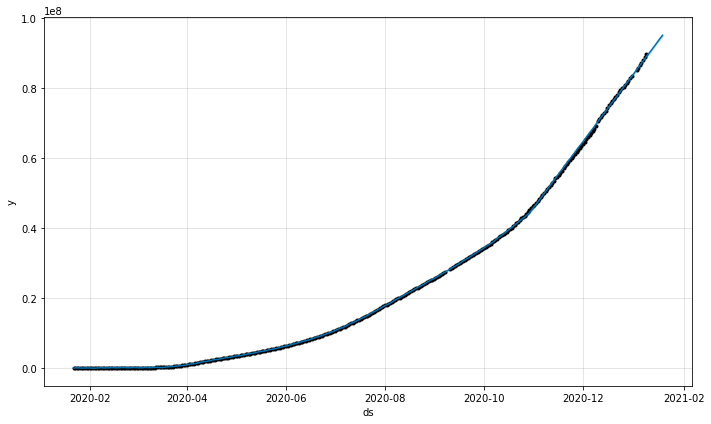

In [ ]:
#plotting
model.plot(forecast_df);

The black dots are our 350 datapoints, the blue line is the prediction for the future date. 

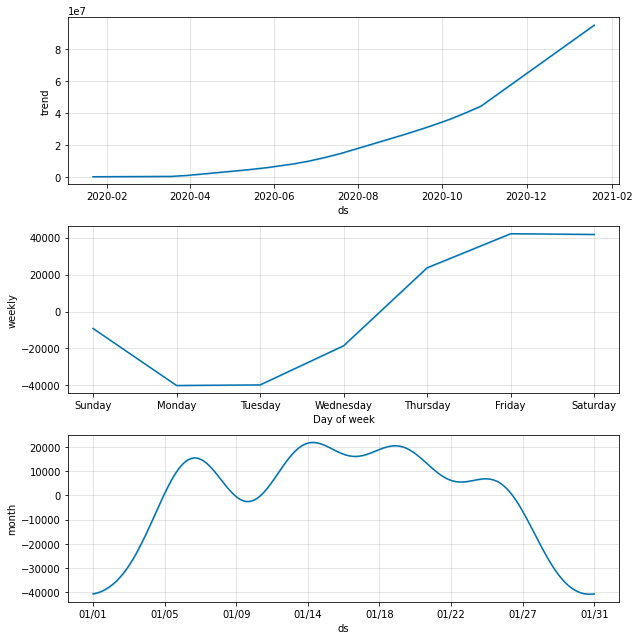

In [ ]:
model.plot_components(forecast_df);

From these plots we can see that the overal **trend** is rising.

From weekly plot, we can see that the confirmed cases are rising during the weekends and falling on Mondays and Tuesdays.

(It is what we added)From the Monthly plots, we can see that the confirmed cases rises during 5th of the month and oscillates and reaches the minimum at the month end.

In [ ]:
test_c

,ds,y
350,9/8/20,27605680
351,9/9/20,27890154


In [ ]:
#for plotting we change the format of date and lets drop ds/ set index to dates
test_c["dates"] = pd.to_datetime(test_c["ds"])
test_c

,ds,y,dates
dates,,,
2020-09-08,9/8/20,27605680,2020-09-08
2020-09-09,9/9/20,27890154,2020-09-09


In [ ]:
test_c = test_c.set_index("dates")
test_c = test_c[["y"]]
test_c

,y
dates,
2020-09-08,27605680
2020-09-09,27890154


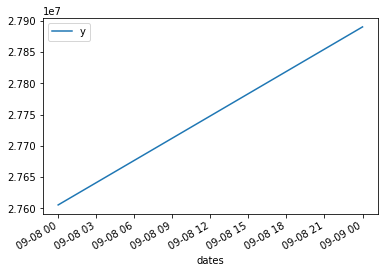

In [ ]:
test_c.plot()

If we increase of test df, then our predicted trend and our test data will match. lets try those for recovered cases.


## Recovered cases forecast:

In [ ]:
recovered_df

,ds,y
0,1/22/20,28.0
1,1/23/20,30.0
2,1/24/20,38.0
3,1/25/20,84.0
4,1/26/20,62.0
...,...,...
347,9/5/20,21492490.0
348,9/6/20,21387058.0
349,9/7/20,21515069.0
350,9/8/20,22040190.0


In [ ]:
#train test split
train_r = recovered_df[:345]
test_r = recovered_df[345:]
train_r

,ds,y
0,1/22/20,28.0
1,1/23/20,30.0
2,1/24/20,38.0
3,1/25/20,84.0
4,1/26/20,62.0
...,...,...
340,9/26/20,33531557.0
341,9/27/20,26961920.0
342,9/28/20,27257542.0
343,9/29/20,26961830.0


You need to retrain your model every time you want to generate a new prediction

In [ ]:
model_r = Prophet()

In [ ]:

#fitting the model on recovered train ds
model_r.fit(train_r)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
#Future dates
future_recovered_dates = model_r.make_future_dataframe(periods=7)

In [ ]:
future_recovered_dates

,ds
0,2020-01-22
1,2020-01-23
2,2020-01-24
3,2020-01-25
4,2020-01-26
...,...
347,2021-01-12
348,2021-01-13
349,2021-01-14
350,2021-01-15


In [ ]:
#forecast
forecast_recovered = model_r.predict(future_recovered_dates)

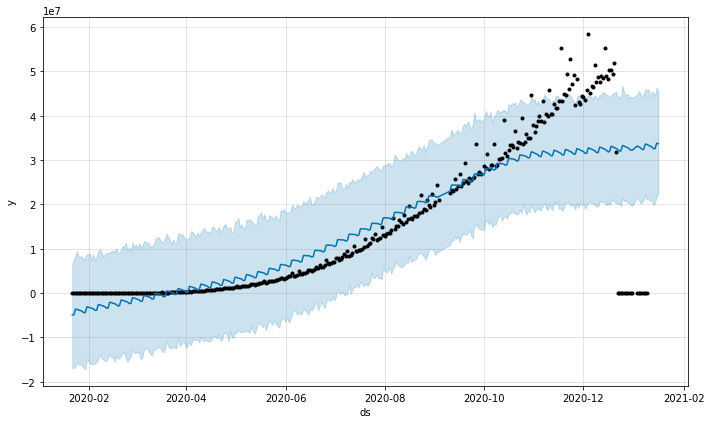

In [ ]:
#plotting
model_r.plot(forecast_recovered);

Since there are some datapoints in recovered dataset is dependent upon confirmed ds and also some datapoints are weird, the model couldn't do a better job in prediciting it.

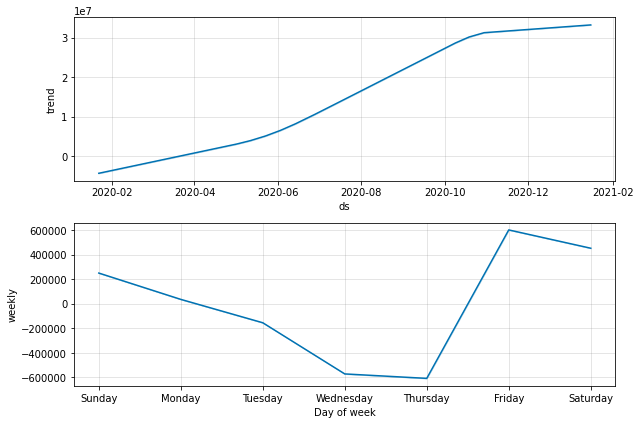

In [ ]:
model_r.plot_components(forecast_recovered);

In [ ]:
test_r
#7 days

,ds,y
345,9/30/20,28943857.0
346,9/4/20,20663668.0
347,9/5/20,21492490.0
348,9/6/20,21387058.0
349,9/7/20,21515069.0
350,9/8/20,22040190.0
351,9/9/20,27739206.0


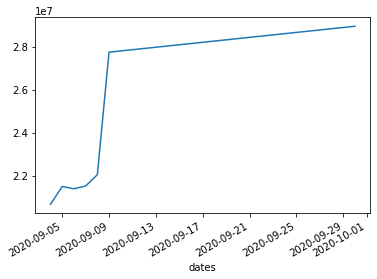

In [ ]:

test_r['dates'] = pd.to_datetime(test_r['ds'])
test_r = test_r.set_index("dates")
test_r = test_r["y"]
test_r.plot();

we can clearly see that the last few days of our test data, has ernormous fluctuation, it directlt jumped from 2.2e^7 to 2.8e^7; this is why our model could not capture the trend clearly. when we tried for less no. of days(in test data) during confirmed forecast, we achieved somewhat satisfying results. 